In [2]:
import ast
import json
import math
from os import path
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D  
import seaborn as sns
import numpy as np
from Bio import SeqIO
from sklearn.linear_model import LogisticRegression

# Figure 2: Rates of adaptation in the receptor-binding proteins of viruses that are known to evolve anitgenically or be antigenically stable

Plot the estimated rate of adaptation in the receptor binding protein of viruses that have been experimentally-shown to evolve antigenically (H3N2, H1N1, Vic, Yam, 229E) and those that have been shown to be antigenically stable (measles, Flu C). Cite the references for experimental validation

In [3]:
#read in colors from the manuscript_colors config file
color_config_json = f'config/manuscript_colors.json'
with open(color_config_json) as json_handle:
    colors = json.load(json_handle)

In [4]:
def readin_virus_config(virus):
    config_json = f'config/adaptive_evo_config_{virus}.json'

    with open(config_json) as json_handle:
        configs = json.load(json_handle)
        
    return configs

In [5]:
def get_rate(virus_and_subtype, method):
    """
    Get rates of adaptation for the receptor-binding protein of each virus
    Return rates and 95CIs given in adaptive muts per codon per year x10-3
    """
    
    
    if 'dengue' in virus_and_subtype:
        virus = 'dengue'
        subtype = 'denv'+virus_and_subtype.split('dengue')[1]
        virus_and_subtype = 'dengue_'+subtype
    elif 'hepatitisA' in virus_and_subtype:
        virus = virus_and_subtype
        subtype=None
    else:
        if '_' in virus_and_subtype:
            virus = virus_and_subtype.split('_')[0]
            subtype = virus_and_subtype.split('_')[1]
        else:
            virus = virus_and_subtype
            subtype = None
            
    #read in configs for this virus
    configs = readin_virus_config(virus)
    receptor_binding_gene = configs['receptor_binding']['virus_gene']

    
    #use time window length depending on the available data: 
    #if the analysis covers 10 years or less, use window of length 3years
    #if the analysis is longer, use window length of 5 years
    #this is determined in the determine_timewindow.ipynb notebook
    if virus_and_subtype in ['h1n1pdm', 'mumps']:
        window, minseqs = 3, 3
    else:
        window, minseqs = 5, 3

    if method=='bhatt':
        json_name = f'bhatt_results/bhatt_results_nextstrain_{window}_{minseqs}/{virus_and_subtype}_{receptor_binding_gene}_bhatt_analysis_bootstrapped.json'
    elif method=='kistler':
        json_name = f'adaptation_results/results/{virus_and_subtype}_{receptor_binding_gene}_{window}_{minseqs}_adaptation_bootstrapped.json'

    if path.exists(json_name):
        with open(json_name) as json_handle:
            json_dict = json.load(json_handle)
            (window_midpoint, adaptive_substitutions, 
             adaptive_substitutions_per_codon, 
             rate_of_adaptation, bootstrap_adaptive_substitutions, 
             bootstrap_adaptive_substitutions_per_codon, 
             bootstrap_rate_of_adaptation) = (json_dict['window_midpoint'], 
                                              json_dict['adaptive_substitutions'], 
                                              json_dict['adaptive_substitutions_per_codon'], 
                                              json_dict['rate_of_adaptation'], 
                                              json_dict['bootstrap_adaptive_substitutions'], 
                                              json_dict['bootstrap_adaptive_substitutions_per_codon'], 
                                              json_dict['bootstrap_rate_of_adaptation'])

        bs_slope_sci = [x * (10**3) for x in bootstrap_rate_of_adaptation]
        lower_95ci = np.percentile(sorted(bs_slope_sci), 2.5)
        upper_95ci = np.percentile(sorted(bs_slope_sci), 97.5)
    else:
        print(virus_and_subtype)


    rb_rate = {virus_and_subtype: {'gene': receptor_binding_gene, 
                                   'color': colors['colors'][virus_and_subtype],
                                   'edge_color': colors['edge_colors'][virus_and_subtype],
                                   'rate':rate_of_adaptation* (10**3), 'upper_95ci':upper_95ci, 
                                   'lower_95ci':lower_95ci}}
    
    return rb_rate
    

In [6]:
#make the virus name more legible
legible_titles_viruses = {'229e': 'Coronavirus 229E', 'h3n2': 'Influenza A/H3N2', 
                          'vic': 'Influenza B/Vic', 'yam': 'Influenza B/Yam', 
                          'h1n1pdm': 'Influenza A/H1N1pdm', 'influenzaC_Yamagata':'Influenza C/Yamagata', 
                          'measles': 'Measles', 'hepatitisA_IA': 'Hepatitis A-IA', 'hepatitisB_D3': 'Hepatitis B-D3',
                          'adenovirusB3': 'Adenovirus B-3', 'adenovirusB7': 'Adenovirus B-7'
                         }

In [7]:
#citations for experimental validation
#229e: (https://doi.org/10.1371/journal.ppat.1009453)
#fluC: (https://doi.org/10.1016/j.jcv.2014.06.017)
#measles: (https://doi.org/10.1128/JVI.03029-12), (https://doi.org/10.1016/j.xcrm.2021.100225)
#h3n2: (https://doi.org/110.1126/science.1097211)
#vic, yam, h1n1, h3n2: (https://doi.org/10.7554/eLife.01914)
#h1n1pdm, ferret model (not exactly what I want): (https://doi.org/10.1371/journal.ppat.1003354)

citations = {'229e': 'Eguia et al, 2021', 
            'h3n2': 'Smith et al, 2004', 
            'vic': 'Bedford et al, 2014', 
            'yam': 'Bedford et al, 2014', 
            'h1n1pdm': 'Bedford et al, 2014', 
            'influenzaC_Yamagata':'Matsuzaki et al, 2014', 
            'measles': 'Tahara et al, 2013;\nMuñoz-Alía et al, 2021',
            'hepatitisA_IA': 'vaccine strains from 1960 and 1976',
             'hepatitisB_D3': 'vaccine strain from 1982 https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7563454/'
                         }

In [8]:
antigenically_evolving = ['h3n2','vic', '229e']
antigenically_stable = ['hepatitisA_IA','influenzaC_Yamagata', 'measles']

In [9]:
def compute_threshold(method):
    """
    Use logistic regression to calculate the threshold for antigenic evolution
    """
    #list of rates
    x = []
    #list of binary evolves antigenically (1) or not (0)
    y = []
    
    
    for virus_and_subtype in antigenically_stable:
        rb_rate = get_rate(virus_and_subtype, method)
        if 'dengue' in virus_and_subtype:
            virus_and_subtype = 'dengue'+'_denv'+virus_and_subtype.split('dengue')[1]
        x.append(rb_rate[virus_and_subtype]['rate'])
        y.append(0)
        
    for virus_and_subtype in antigenically_evolving:
        rb_rate = get_rate(virus_and_subtype, method)
        x.append(rb_rate[virus_and_subtype]['rate'])
        y.append(1)
        
    x = np.array(x).reshape(-1, 1)
    y = np.array(y)
        
    logreg = LogisticRegression()
    
    logreg.fit(x, y)

    X_test = np.arange(0.3,1.4, step=0.01).reshape(-1, 1)
    Y_predict = logreg.predict(X_test).tolist()
    
    #find where prediction switches from 0 to 1
    index_first_1 = Y_predict.index(1)
    antigenic_threshold = X_test[index_first_1]
    
    return antigenic_threshold[0].round(2)

In [10]:
print(f'threshold for constant outgroup: {compute_threshold("bhatt")}\nthreshold for update outgroup: {compute_threshold("kistler")}')




threshold for constant outgroup: 0.96
threshold for update outgroup: 1.18


In [20]:
def compare_rates_between_known_viruses_flip(ax, method): 
    """
    Plot the estimated rate of adaptation in the receptor-binding protein for each virus 
    that is experimentally-validated. 
    """
    
    data_to_plot = {}
    
    for virus_and_subtype in antigenically_evolving:
        rb_rate = get_rate(virus_and_subtype, method)
        rb_rate[virus_and_subtype].update({'known':'antigenically_evolving'})
        data_to_plot.update(rb_rate)
        
    for virus_and_subtype in antigenically_stable:
        rb_rate = get_rate(virus_and_subtype, method)
        rb_rate[virus_and_subtype].update({'known':'antigenically_stable'})
        data_to_plot.update(rb_rate)

    
    
    #y coordinate counter
    ypos = 0
    #list of xtick labels
    y_labels = []
    y_ticks = []
    
    #add a filler row to label the threshold under H3N2
    y_ticks.append(ypos)
    y_labels.append('')
    ypos+=0.5
    
    for virus, vdata in data_to_plot.items():
        rate = vdata['rate']
        
        if vdata['known'] == 'antigenically_evolving':
            ax.hlines(ypos, vdata['lower_95ci'], vdata['upper_95ci'], color=vdata['edge_color'], linewidth=1.5)
            ax.plot(rate, ypos, 'o', ms=12, color=vdata['color'], 
                       markeredgewidth=1.5, markeredgecolor=vdata['edge_color'])
        else:
            ax.hlines(ypos, vdata['lower_95ci'], vdata['upper_95ci'], color=vdata['color'], linewidth=1.5)
            ax.plot(rate, ypos, 'o', ms=12, color='white', 
                       markeredgewidth=1.5, markeredgecolor=vdata['color'])
        #label the rate of adaptation next to virus
        ax.text(rate+0.22, ypos+0.2,
                       f'rate = {round(rate,2):.2f} × '+r'$10^{-3}$', fontsize=9,
                       color=vdata['edge_color'])
        
        #keep track of name and X coordinate of virus
        y_ticks.append(ypos)
        gene = vdata['gene'].upper()
        y_labels.append(f'{legible_titles_viruses[virus]}\n{gene}')
        
        #increase ypos for next virus
        #only increase by a slight amount for measles, to give a spacer at the top
        if virus=='measles':
            ypos+=0.5
        else:
            ypos+=1
    
    #add spacer to the top
    y_ticks.append(ypos)
    y_labels.append('')
    
        
    ax.set_yticks(y_ticks)
    ax.set_yticklabels(y_labels) 

    
    #vertical line dividing the viruses that evolve antigenically and those that don't
    #find threshold using logistic regression
    antigenic_threshold = compute_threshold(method)
    ax.axvline(antigenic_threshold, color='#d3d3d3', linestyle=(0, (5, 7)), zorder=1)
    #annotate threshold
    ax.text(antigenic_threshold-0.05, 0.1, 'threshold: ', fontsize=8, color='#808080', ha='right')
    ax.text(antigenic_threshold+0.05, 0.1, f'{antigenic_threshold} × '+r'$10^{-3}$', fontsize=9, color='#808080', ha='left')
    
    #add legend
    handles = [Line2D([], [], color="white", marker='o', markerfacecolor="white", markersize=8, 
                      markeredgewidth=1.5, markeredgecolor="#808080"),
              Line2D([], [], color="white", marker='o', markerfacecolor="#808080", markersize=8, 
                      markeredgewidth=1.5, markeredgecolor="#808080")]
    leg = ax.legend(handles, ['Antigenically Stable', 'Antigenically Evolving'],
                          bbox_to_anchor=(0.95, 1.0), frameon=True, labelspacing = 0.7,
                              handletextpad=0.1, borderpad=0.75)
    #add border    
    leg.get_frame().set_edgecolor('#d3d3d3')
    
    
    #x-axis label
    ax.set_xlabel('Adaptive Muts per Codon per Year $(× 10^{-3})$\nin Receptor-Binding Protein')

        
    #remove box around plot
    sns.despine()
    


In [12]:
def plot_influenza_relationship(ax, method):
    """
    Plot the relationship between rate of adaptation in HA1 and how often vaccine gets updated
    """
    
    influenza_virues = ['h3n2', 'h1n1pdm', 'vic', 'yam']
    vaccine_strains_2012to2022 = {'h3n2':9, 'h1n1pdm':5, 'vic':4, 'yam':3}
    vaccine_updates_2012to2022 = {k:v-1 for k,v in vaccine_strains_2012to2022.items()}
    data_to_plot = []
    
    for virus in influenza_virues:
        rb_rate = get_rate(virus, method)
        rb_rate[virus].update({'vaccine_strains':vaccine_strains_2012to2022[virus]})
        rb_rate[virus].update({'vaccine_updates':vaccine_updates_2012to2022[virus]})
        rb_rate[virus].update({'virus':virus})
        data_to_plot.append(rb_rate[virus])
        
    df= pd.DataFrame(data_to_plot)

    for k,v in df.iterrows():
        #plot error bars
        ax.hlines(v['vaccine_updates'], v['lower_95ci'], v['upper_95ci'], color=v['edge_color'], linewidth=1.0)
        #plot data points
        ax.scatter(x =v['rate'], y=v['vaccine_updates'], s=60, color=v['color'], 
                       linewidths=1.5, edgecolor=v['edge_color'], zorder=100)
        #label the influenza viruses
        ax.text(v['rate']+0.5, v['vaccine_updates']-0.5, legible_titles_viruses[v['virus']].split(' ')[1], 
                color=v['color'], fontsize=8)

        
    ax.set_ylim([0,df['vaccine_updates'].max()+1])
        
    #x-axis and y-axis labels
    ax.set_xlabel('Adaptive Muts per Codon per Year $(× 10^{-3})$\nin HA1')
    ax.set_ylabel('Number of Vaccine Updates\n2012-2022')
        

In [13]:
def combine_fig_panels(method='kistler', filename=False):
    """
    Plot Figure 2 panels. 
    A: threshold of antigenic evolution as estimated from the rates of adaptation in the receptor-binding protein
    of known antigenically-evolving and known antigenically-stable viruses
    B: relationship between rate of adaptation and number of times vaccine has been updated for influenza viruses
    """
    
    #set up figure grid for all panels
    fig, axs = plt.subplots(1, 2, 
                            figsize=(8,3),facecolor='w', 
                            gridspec_kw={'width_ratios':[2,1]}, sharex='col')
    #plot styling
    sns.set_style("white")
    plt.rcParams['axes.labelsize'] = 8
    plt.rcParams['axes.labelweight'] = 'bold'
    plt.rcParams['axes.titlesize'] = 10
    plt.rcParams['xtick.labelsize'] = 8
    plt.rcParams['ytick.labelsize'] = 8
    plt.rcParams['legend.fontsize'] = 8
    plt.rcParams['figure.dpi']= 300
    
    #plot the threshold panel
    compare_rates_between_known_viruses_flip(axs[0], method)
    
    #plot the influenza adaptation/vaccine update relationship panel
    plot_influenza_relationship(axs[1], method)
    
    
    #figure panel labels
    panel_labels = ['A', 'B']
    for i in range(len(panel_labels)):
        ax = axs[i]
        ax.text(-0.2, 0.99, panel_labels[i], horizontalalignment='center', 
               verticalalignment='center', weight='bold', fontsize=14, transform=ax.transAxes)
        
    if filename:
        fig.savefig(filename, dpi=300, bbox_inches='tight', transparent=False, facecolor='white')
    

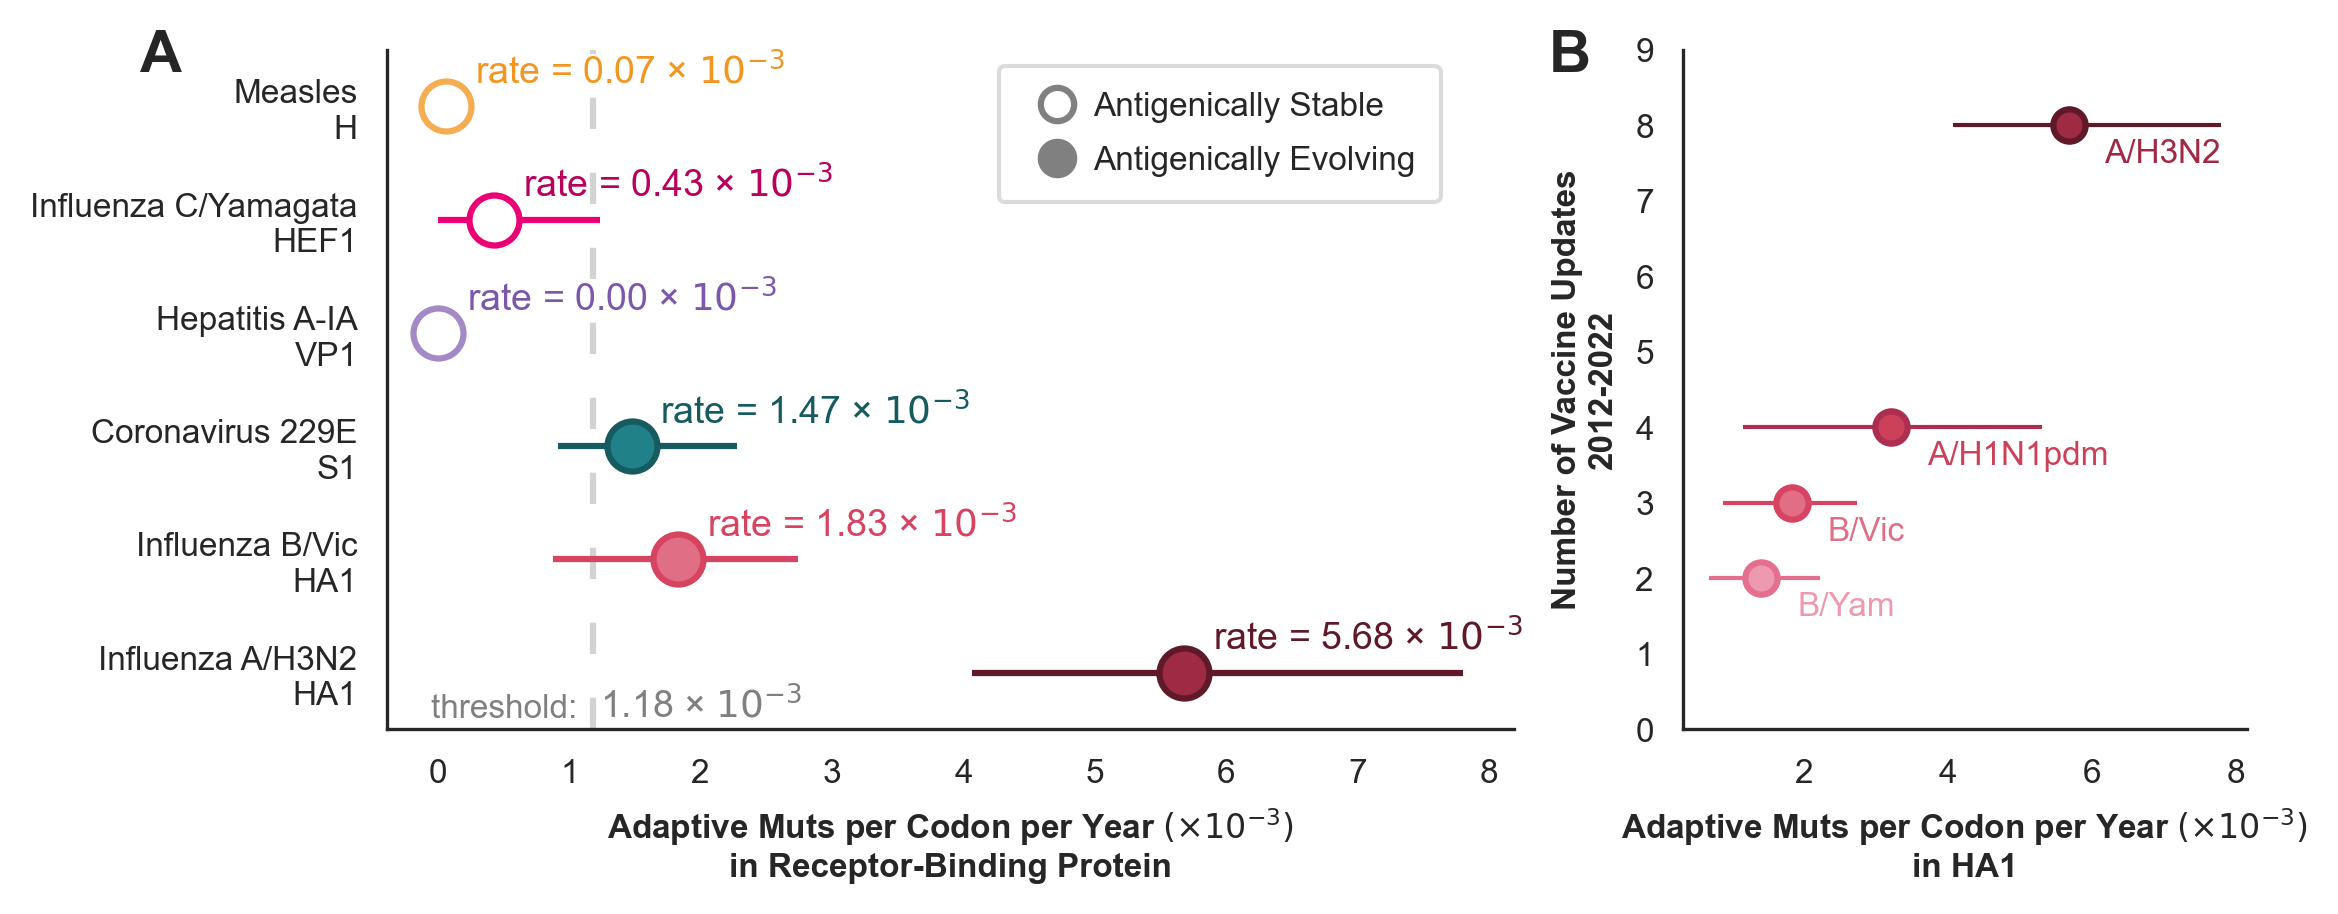

In [22]:
combine_fig_panels(method='kistler', filename='manuscript_figures/Figure2_Threshold.png')